## Description:
这个笔记本主要是分析下数据与简单的数据预处理，主要包括：
1. 数据简单分析，聚焦用户的点击序列
2. 数据预处理主要是用户数据的性别，年龄确定与编码， 文章画像数据的缺失值填充与编码
3. 日志数据拼接上用户和文章画像，并保存

## 导入包

In [1]:
import os
import time
import random
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 导入数据集

In [2]:
base_path = 'all_data'
doc_info_path = os.path.join(base_path, 'doc_info.txt')
train_data_path = os.path.join(base_path, 'sample_2w_data.csv')
user_info_path = os.path.join(base_path, 'user_info.txt')

In [33]:
# 读取数据
doc_info = pd.read_csv(doc_info_path, delimiter='\t', names=['article_id', 'title','ctime', 'img_num', 'cat_1', 'cat_2', 'key_words'])
train_data = pd.read_csv(train_data_path)
user_info = pd.read_csv(user_info_path, delimiter='\t', names=['user_id', 'device', 'os', 'province', 'city', 'age', 'gender'])

In [4]:
print(doc_info.shape, train_data.shape, user_info.shape)

(592749, 7) (3939989, 8) (1538384, 7)


## 初识数据

In [5]:
doc_info.head()

,article_id,title,ctime,img_num,cat_1,cat_2,key_words
0,349635709,"拿到c1驾照后,实习期扣分了会怎样?扣12分驾照会吊销么?",1572519971000,9,汽车,汽车/用车,"上班族:8.469502,买车:8.137443,二手车:9.022247,副页:11.21..."
1,361653323,"疫情谣言粉碎机丨接种新冠疫苗后用麻药或致死?盘点最新疫情谣言,别被忽悠了",1624522285000,1,健康,健康/疾病防护治疗及西医用药,"医生:14.760494,吸烟:16.474872,板蓝根:15.597788,板蓝根^^熏..."
2,426732705,"实拍本田飞度:空间真大,8万出头工薪族可选,但内饰能忍?",1610808303000,9,汽车,汽车/买车,"155n:8.979802,polo:7.951116,中控台:5.954278,中网:7...."
3,430221183,搭载135kw电机比亚迪秦plus纯电动版外观更精致,1612581556000,2,汽车,汽车/买车,"etc:12.055207,代表:8.878175,内饰:5.342025,刀片:9.453..."
4,441756326,【提车作业】不顾他人眼光帕萨特phev俘获30老男人浪子心,1618825835000,23,汽车,汽车/买车,"丰田凯美瑞:12.772149,充电器:8.394001,品牌:8.436843,城市:7...."


In [6]:
user_info.head()

,user_id,device,os,province,city,age,gender
0,1000372820,TAS-AN00,Android,广东,广州,"A_0_24:0.404616,A_25_29:0.059027,A_30_39:0.516...","female:0.051339,male:0.948661"
1,1000652892,PACM00,Android,河北,唐山,"A_0_24:0.615458,A_25_29:0.086233,A_30_39:0.141...","female:0.280295,male:0.719705"
2,1000908852,MI6X,Android,上海,上海,"A_0_24:0.123255,A_25_29:0.208225,A_30_39:0.298...","female:0.000000,male:1.000000"
3,1001168798,iPhone11,IOS,NaN,NaN,"A_0_24:0.436296,A_25_29:0.489370,A_30_39:0.061...","female:0.870710,male:0.129290"
4,1001305614,M2103K19C,Android,江苏,苏州,"A_0_24:0.006632,A_25_29:0.043408,A_30_39:0.350...","female:0.000000,male:1.000000"


In [7]:
train_data.head()

,user_id,article_id,expo_time,net_status,flush_nums,exop_position,click,duration
0,1000541010,464467760,2021-06-30 09:57:14,2,0,13,1,28
1,1000541010,463850913,2021-06-30 09:57:14,2,0,15,0,0
2,1000541010,464022440,2021-06-30 09:57:14,2,0,17,0,0
3,1000541010,464586545,2021-06-30 09:58:31,2,1,20,0,0
4,1000541010,465352885,2021-07-03 18:13:03,5,0,18,0,0


In [8]:
# 交互数据中用户和文章数量
train_data['user_id'].nunique()

20000

In [9]:
train_data['article_id'].nunique()  # 万篇文章

114620

In [10]:
# 曝光时间探索  毫秒级时间戳 
# 转换成python的时间格式
#train_data['expo_time'] = train_data['expo_time'].apply(lambda x: datetime.fromtimestamp(float(x)/1000) \
#                                                        .strftime('%Y-%m-%d %H:%M:%S'))
train_data['expo_time'] = pd.to_datetime(train_data['expo_time'])

In [11]:
print(train_data['expo_time'].min(), "  ", train_data['expo_time'].max())   # 从6月24到7月6号  12天的行为日志
# 后面把从6月24到7月5号的行为数据当做训练集， 7月6号的数据当做测试集进行测试

2021-06-30 00:00:01    2021-07-06 23:59:59


In [12]:
train_data['click'].value_counts()    

0    3353933
1     586056
Name: click, dtype: int64

## 点击序列分析

In [13]:
# 选出点击的来
click_df = train_data[train_data['click']==1]

In [14]:
click_df['date'] = click_df['expo_time'].dt.date

In [31]:
click_df.shape

(234045, 9)

In [15]:
click_df['user_id'].nunique()

20000

In [16]:
click_df['article_id'].nunique()

48383

In [17]:
# 看看每一天的点击分布
click_df.groupby('date')['click'].apply(lambda x: x.count())

date
2021-06-30     57053
2021-07-01     55657
2021-07-02     53724
2021-07-03     50291
2021-07-04     78487
2021-07-05    146634
2021-07-06    144210
Name: click, dtype: int64

In [18]:
# 看看每个用户的次数分布
click_df.groupby('user_id')['click'].apply(lambda x: x.count()).describe()

count    20000.000000
mean        29.302800
std         19.568923
min         10.000000
25%         14.000000
50%         23.000000
75%         38.000000
max        100.000000
Name: click, dtype: float64

In [19]:
click_df.groupby('user_id')['click'].apply(lambda x: x.count())

user_id
17340         46
490452        58
4419744       86
4564792       38
5419396       19
              ..
2447162784    30
2447169712    18
2447202996    10
2447212098    11
2447231894    17
Name: click, Length: 20000, dtype: int64

In [20]:
pd.DataFrame(click_df.groupby('user_id')['click'].apply(lambda x: x.count())).value_counts()

click
10       1217
11       1082
12        988
13        914
14        816
         ... 
99         25
95         23
97         23
100        20
93         16
Length: 91, dtype: int64

In [44]:
click_nums = pd.DataFrame(click_df.groupby('user_id')['click'].apply(lambda x: x.count()))

In [50]:
click_nums.shape

(31164, 1)

一个人最多点击了1111次，这种制作划窗的时候，肯定要注意下， 把次数限制在40吧

窗口的话， 这里得划分下：
* 小于10的， 步长为1进行滑动
* 长度10-20的， 步长为2滑动
* 长度20-30的， 步长为3滑动
* 长度30-40的，步长为4滑动


<AxesSubplot:>

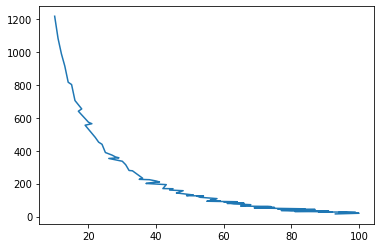

In [21]:
click_df.groupby('user_id')['click'].apply(lambda x: x.count()).value_counts().plot()
# 这个如果用划窗的话， 历史点击次数太多的，这种不好用  需要限制下点击次数，比如对于不活跃的用户，可以使用划窗数据

## 看点击数据中的时长


In [23]:
click_df['duration'].value_counts()

3       4638
4       4623
6       4512
5       4478
7       4288
        ... 
1138       1
1678       1
1544       1
1318       1
2266       1
Name: duration, Length: 1771, dtype: int64

感觉得把这种观看时间太短的去掉

In [24]:
click_df.shape

(586056, 9)

## 看缺失情况

In [26]:
user_info.isnull().sum()

user_id         0
device      67744
os          67808
province    92260
city        96072
age         59891
gender      58572
dtype: int64

In [27]:
doc_info.isnull().sum()

article_id        0
title             0
ctime           212
img_num         212
cat_1           255
cat_2           256
key_words     10137
dtype: int64

In [63]:
doc_info.shape

(230841, 7)

In [64]:
train_data.isnull().sum()

user_id          0
article_id       0
expo_time        0
net_status       0
flush_nums       0
expo_position    0
click            0
duration         0
dtype: int64

用户画像数据缺失比较多，需要处理， 而doc_info数据可以采用简单填充方式， 关键词目前用不到

## 处理用户数据

In [28]:
user_info.head()

,user_id,device,os,province,city,age,gender
0,1000372820,TAS-AN00,Android,广东,广州,"A_0_24:0.404616,A_25_29:0.059027,A_30_39:0.516...","female:0.051339,male:0.948661"
1,1000652892,PACM00,Android,河北,唐山,"A_0_24:0.615458,A_25_29:0.086233,A_30_39:0.141...","female:0.280295,male:0.719705"
2,1000908852,MI6X,Android,上海,上海,"A_0_24:0.123255,A_25_29:0.208225,A_30_39:0.298...","female:0.000000,male:1.000000"
3,1001168798,iPhone11,IOS,NaN,NaN,"A_0_24:0.436296,A_25_29:0.489370,A_30_39:0.061...","female:0.870710,male:0.129290"
4,1001305614,M2103K19C,Android,江苏,苏州,"A_0_24:0.006632,A_25_29:0.043408,A_30_39:0.350...","female:0.000000,male:1.000000"


age和gender必须得选择出一种来， 根据概率取值选择

In [74]:
user_info.dtypes

user_id      int64
device      object
os          object
province    object
city        object
age         object
gender      object
dtype: object

In [34]:
def get_age_gender(x):
    # 空值注意下
    if pd.isna(x):
        return x
    x_list = x.split(',')
    age_stage_val = list(map(lambda x: x.split(':'), x_list))
    age_stage = list(map(lambda x: x[0], age_stage_val))
    age_val = list(map(lambda x: x[1], age_stage_val))
    return age_stage[np.argmax(age_val)]

user_info['age'] = user_info['age'].apply(lambda x: get_age_gender(x))
user_info['gender'] = user_info['gender'].apply(lambda x: get_age_gender(x))

In [30]:
user_info.head()

,user_id,device,os,province,city,age,gender
0,1000372820,TAS-AN00,Android,广东,广州,A_30_39,male
1,1000652892,PACM00,Android,河北,唐山,A_0_24,male
2,1000908852,MI6X,Android,上海,上海,A_40+,male
3,1001168798,iPhone11,IOS,NaN,NaN,A_25_29,female
4,1001305614,M2103K19C,Android,江苏,苏州,A_40+,male


In [36]:
user_info.isnull().sum()

user_id     0
device      0
os          0
province    0
city        0
age         0
gender      0
dtype: int64

In [35]:
# 填充空值
user_info.fillna('nan', inplace=True)

user数据的编码转换，在这里先不做了， 拼接到日志数据上去，在YouTubeDNN那里统一做

In [32]:
# from sklearn.preprocessing import LabelEncoder
# 编码转换
# cols = user_info.columns[1:]  # Index(['device', 'os', 'province', 'city', 'age', 'gender'], dtype='object')

# for col in cols:
#     enc = LabelEncoder()
#     user_info[col] = enc.fit_transform(user_info[col])

In [37]:
user_info.head()

,user_id,device,os,province,city,age,gender
0,1000372820,TAS-AN00,Android,广东,广州,A_30_39,male
1,1000652892,PACM00,Android,河北,唐山,A_0_24,male
2,1000908852,MI6X,Android,上海,上海,A_40+,male
3,1001168798,iPhone11,IOS,nan,nan,A_25_29,female
4,1001305614,M2103K19C,Android,江苏,苏州,A_40+,male


In [38]:
# 保存一份新数据
user_info.to_csv('data_process/user_info.csv')

## 处理文章数据

In [39]:
doc_info.head()

,article_id,title,ctime,img_num,cat_1,cat_2,key_words
0,349635709,"拿到c1驾照后,实习期扣分了会怎样?扣12分驾照会吊销么?",1572519971000,9,汽车,汽车/用车,"上班族:8.469502,买车:8.137443,二手车:9.022247,副页:11.21..."
1,361653323,"疫情谣言粉碎机丨接种新冠疫苗后用麻药或致死?盘点最新疫情谣言,别被忽悠了",1624522285000,1,健康,健康/疾病防护治疗及西医用药,"医生:14.760494,吸烟:16.474872,板蓝根:15.597788,板蓝根^^熏..."
2,426732705,"实拍本田飞度:空间真大,8万出头工薪族可选,但内饰能忍?",1610808303000,9,汽车,汽车/买车,"155n:8.979802,polo:7.951116,中控台:5.954278,中网:7...."
3,430221183,搭载135kw电机比亚迪秦plus纯电动版外观更精致,1612581556000,2,汽车,汽车/买车,"etc:12.055207,代表:8.878175,内饰:5.342025,刀片:9.453..."
4,441756326,【提车作业】不顾他人眼光帕萨特phev俘获30老男人浪子心,1618825835000,23,汽车,汽车/买车,"丰田凯美瑞:12.772149,充电器:8.394001,品牌:8.436843,城市:7...."


In [40]:
doc_info['ctime'].mode()

0    1625400960000.0
dtype: object

In [41]:
doc_info['ctime'] = doc_info['ctime'].str.replace('Android', '1625400960000')
doc_info['ctime'].fillna('1625400960000', inplace=True)

时间列处理

In [42]:
doc_info['ctime'] = doc_info['ctime'].apply(lambda x: datetime.fromtimestamp(int(x)/1000) \
                                                        .strftime('%Y-%m-%d %H:%M:%S'))
doc_info['ctime'] = pd.to_datetime(doc_info['ctime'])

In [43]:
doc_info.head()

,article_id,title,ctime,img_num,cat_1,cat_2,key_words
0,349635709,"拿到c1驾照后,实习期扣分了会怎样?扣12分驾照会吊销么?",2019-10-31 19:06:11,9,汽车,汽车/用车,"上班族:8.469502,买车:8.137443,二手车:9.022247,副页:11.21..."
1,361653323,"疫情谣言粉碎机丨接种新冠疫苗后用麻药或致死?盘点最新疫情谣言,别被忽悠了",2021-06-24 16:11:25,1,健康,健康/疾病防护治疗及西医用药,"医生:14.760494,吸烟:16.474872,板蓝根:15.597788,板蓝根^^熏..."
2,426732705,"实拍本田飞度:空间真大,8万出头工薪族可选,但内饰能忍?",2021-01-16 22:45:03,9,汽车,汽车/买车,"155n:8.979802,polo:7.951116,中控台:5.954278,中网:7...."
3,430221183,搭载135kw电机比亚迪秦plus纯电动版外观更精致,2021-02-06 11:19:16,2,汽车,汽车/买车,"etc:12.055207,代表:8.878175,内饰:5.342025,刀片:9.453..."
4,441756326,【提车作业】不顾他人眼光帕萨特phev俘获30老男人浪子心,2021-04-19 17:50:35,23,汽车,汽车/买车,"丰田凯美瑞:12.772149,充电器:8.394001,品牌:8.436843,城市:7...."


In [46]:
doc_info.isnull().sum()

article_id        0
title             0
ctime             0
img_num           0
cat_1             0
cat_2             0
key_words     10137
dtype: int64

In [45]:
# 填充其他列的缺失
doc_info['img_num'].fillna(0.0, inplace=True)
doc_info['cat_1'].fillna(doc_info['cat_1'].mode()[0], inplace=True)
doc_info['cat_2'].fillna(doc_info['cat_2'].mode()[0], inplace=True)

In [139]:
doc_info.shape

(592749, 7)

## 处理日志数据
日志数据先拼接上用户画像，保存一份

In [47]:
train_data.head()

,user_id,article_id,expo_time,net_status,flush_nums,exop_position,click,duration
0,1000541010,464467760,2021-06-30 09:57:14,2,0,13,1,28
1,1000541010,463850913,2021-06-30 09:57:14,2,0,15,0,0
2,1000541010,464022440,2021-06-30 09:57:14,2,0,17,0,0
3,1000541010,464586545,2021-06-30 09:58:31,2,1,20,0,0
4,1000541010,465352885,2021-07-03 18:13:03,5,0,18,0,0


In [48]:
train_data = train_data.merge(user_info, on='user_id', how='left')
train_data_new = train_data.merge(doc_info[['article_id', 'ctime', 'img_num', 'cat_1', 'cat_2']], on='article_id', how='left')

In [49]:
train_data_new.head()

,user_id,article_id,expo_time,net_status,flush_nums,exop_position,click,duration,device,os,province,city,age,gender,ctime,img_num,cat_1,cat_2
0,1000541010,464467760,2021-06-30 09:57:14,2,0,13,1,28,V2054A,Android,上海,上海,A_0_24,female,2021-06-29 14:46:43,3,娱乐,娱乐/港台明星
1,1000541010,463850913,2021-06-30 09:57:14,2,0,15,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-27 22:29:13,11,时尚,时尚/女性时尚
2,1000541010,464022440,2021-06-30 09:57:14,2,0,17,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-28 12:22:54,7,农村,农村/农业资讯
3,1000541010,464586545,2021-06-30 09:58:31,2,1,20,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-29 13:25:06,5,娱乐,娱乐/港台明星
4,1000541010,465352885,2021-07-03 18:13:03,5,0,18,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-07-02 10:43:51,18,娱乐,娱乐/港台明星


In [50]:
train_data_new.isnull().sum()

user_id          0
article_id       0
expo_time        0
net_status       0
flush_nums       0
exop_position    0
click            0
duration         0
device           0
os               0
province         0
city             0
age              0
gender           0
ctime            0
img_num          0
cat_1            0
cat_2            0
dtype: int64

In [54]:
train_data_new.head()

,user_id,article_id,expo_time,net_status,flush_nums,exop_position,click,duration,device,os,province,city,age,gender,ctime,img_num,cat_1,cat_2
0,1000541010,464467760,2021-06-30 09:57:14,2,0,13,1,28,V2054A,Android,上海,上海,A_0_24,female,2021-06-29 14:46:43,3,娱乐,娱乐/港台明星
1,1000541010,463850913,2021-06-30 09:57:14,2,0,15,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-27 22:29:13,11,时尚,时尚/女性时尚
2,1000541010,464022440,2021-06-30 09:57:14,2,0,17,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-28 12:22:54,7,农村,农村/农业资讯
3,1000541010,464586545,2021-06-30 09:58:31,2,1,20,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-06-29 13:25:06,5,娱乐,娱乐/港台明星
4,1000541010,465352885,2021-07-03 18:13:03,5,0,18,0,0,V2054A,Android,上海,上海,A_0_24,female,2021-07-02 10:43:51,18,娱乐,娱乐/港台明星


In [55]:
train_data_new.to_csv('data_process/train_data.csv')

新保存的数据集里面小问题记录：
1. 这里面很多被点击的新闻并没有新闻画像
2. 好多新闻的曝光时间要大于创建时间，这其实是错误数据， 考虑到数据量的关系，先不做处理

这些问题， 通过重新采样， 重新处理数据得以解决